# Partie Computer Vision

Dans cette partie, on s'intéresse à la localisation des doigts du pianiste dans une image donnée.

L'approche suivie est la suivante :

1. [Exploration](#Exploration) : affichage des images et histogrammes
2. [Segmentation](#Segmentation) : extraction de main
3. [Localisation](#Localisation-des-doigts) des pointes de doigts

In [13]:
# Import des librairies
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import sys
cv = cv2

sys.modules.pop("utils", None)
from utils import *

os.makedirs("output", exist_ok=True)

## Exploration

Nous avons dessiné un piano sur une feuille de papier et pris différentes photos correspondant aux situations suivantes :
    
- Scène vide : pas de doigt sur l'image.
- Scène avec doigts : main présente sur l'image avec un ou plusieurs doigts pointant sur des touches du piano.

Les images ont été prises en vue de dessus. La feuille de papier était placée sur une table de couleur foncée et apparente sur les bords de l'image.

### Affichage des images

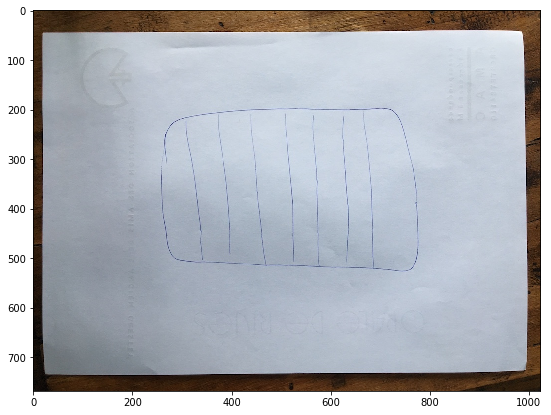

In [2]:
vide, _ = load("./data/images/piano-vide.jpg", gray=False)
show(vide, gray=False);

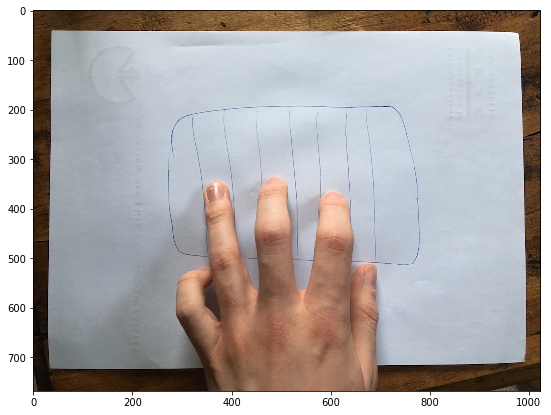

In [3]:
doigt, _ = load("./data/images/piano-doigt.jpg", gray=False)
show(doigt, gray=False);

### Tracé des histogrammes

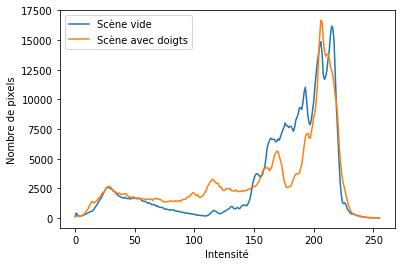

In [4]:
gvide = to_gray(vide)
gdoigt = to_gray(doigt)

plt.plot(histogram(gvide), label="Scène vide")
plt.plot(histogram(gdoigt), label="Scène avec doigts")
plt.xlabel("Intensité")
plt.ylabel("Nombre de pixels")
plt.legend();

L'histogramme ci-dessus montre des différences locales au niveau des pixels de moyenne (80-140) et forte (180-230) intensité. Elles correspondent à la présence ou l'absence du doigt dans l'image et à l'apparition d'ombres lorsque le doigt est présente.

Cette différence est visible sur l'image différence ci-dessous.

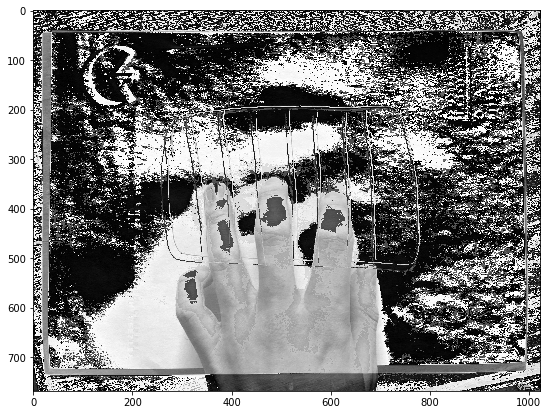

In [5]:
show(to_gray(np.abs(doigt - vide)));

Note : cette image différence montre l'importance de garder la caméra fixe au cours de l'observation de la scène afin de simplifier la détection de changements.

## Segmentation

*Inspiré de [Finger tracking with OpenCV and Python](http://www.benmeline.com/finger-tracking-with-opencv-and-python/).*

Dans cette partie, on construit un détecteur de peau permettant d'extraire la main du pianiste de la scène. La région extraite servira de base pour la localisation des pointes de doigt.

L'approche choisie est de construire un **histogramme de peau** basé sur des imagettes relevées en conditions réelles. Cette approche a l'avantage de pouvoir s'adapter aux conditions d'observation, mais demande une étape de calibration où l'utilisateur doit placer sa main dans une zone de l'image qui lui est indiquée.

In [6]:
from itertools import product


GREEN = (0, 255, 0)
CHANNEL_HUE = 0
CHANNEL_SATURATION = 1


class Rect:
    def __init__(self, top, right, bottom, left, color=GREEN):
        self.top = top
        self.right = right
        self.bottom = bottom
        self.left = left
        self.color = color
    
    def draw(self, img):
        cv2.rectangle(img, (self.left, self.top), (self.right, self.bottom), self.color, 2)
    
    def image(self, img):
        return img[self.top:self.bottom, self.left:self.right]

    
class SkinDetector:
    """Detecteur de peau pour image RGB."""
    
    # Constantes pour le calcul et la projection d'histogramme de peau.
    CHANNELS = [CHANNEL_HUE, CHANNEL_SATURATION]
    # 180 bins pour la teinte, 255 bins pour la saturation.
    BINS = [180, 255]
    # 0° ≤ hue ≤ 180°, 0 ≤ saturation ≤ 255
    RANGES = [0, 180, 0, 255]

    def __init__(self, shape, rect_size=20):
        self.rect_size = rect_size

        # Calcul des régions d'intérêt (grille 3x3 centrée sur l'image).
        self.rects = []
        rows, cols = shape[0], shape[1]
        for i, j in product(range(-1, 2), range(-1, 2)):
            top = int(rows * (0.43 + 0.2 * i))
            left = int(cols * (0.5 + 0.05 * j))
            bottom = top + self.rect_size
            right = left + self.rect_size
            self.rects.append(Rect(top, right, bottom, left))

        self.hist = None

    def hint(self, img):
        """Affichage des régions d'intérêt sur une image."""
        img = img.copy()
        for rect in self.rects:
            rect.draw(img)
        return img

    def fit(self, img):
        """Calcul du modèle de peau à partir d'une image de calibration."""
        # Passage en mode colorimétrique HSV.
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Concaténation horizontale des imagettes de peau.
        concat = np.hstack([rect.image(hsv) for rect in self.rects])

        # Calcul de l'histogramme normalisé.
        # NOTE: c'est un histogramme 2D sur la teinte et la saturation.
        hist = cv2.calcHist([concat], self.CHANNELS, None, self.BINS, self.RANGES)
        cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

        # Enregistrement de l'histogramme.
        self.hist = hist

        return hist

    def project(self, img):
        """Rétro-projection de l'histogramme du peau sur une image."""
        # Conversion de l'image dans l'espace colorimétrique HSV.
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Rétro-projection :
        # proj(x, y) contient la probabilité que hsv(x, y) soit un pixel de peau.
        # Voir aussi : https://docs.opencv.org/3.4.6/dc/df6/tutorial_py_histogram_backprojection.html
        scale = 1  # Hypothèse : main observée de même taille que la main de calibration.
        proj = cv2.calcBackProject([hsv], self.CHANNELS, self.hist, self.RANGES, scale)

        # Convolution du résultat par un masque circulaire.
        # Cette opération "gonfle" les pixels où de la peau a été détectée avec grande probabilité.
        # L'objectif est d'obtenir une région connexe grossière qui englobe toute la main.
        mask = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        cv2.filter2D(proj, -1, mask, proj)
        
        return proj

    def transform(self, img):
        """Extraction de la peau sur une image."""
        assert self.hist is not None, "Le détecteur n'est pas encore calibré. Utiliser `.fit()`."
        
        # Projection de l'histogramme sur l'image.
        proj = self.project(img)

        # Seuillage de la projection pour ne garder que les pixels de peau très probables.
        threshold = 100
        max_val = 255
        _, thresh = cv2.threshold(proj, threshold, max_val, cv2.THRESH_BINARY)

        # Construction du masque RGB.
        thresh = cv2.merge((thresh, thresh, thresh))

        # Intersection booléenne entre l'image et le masque de peau.
        result = cv2.bitwise_and(img, thresh)

        return result

    
calib, _ = load("./data/images/piano-calib.jpg", gray=False)
detector = SkinDetector(calib.shape)

L'utilisateur doit placer sa main sur l'image afin que 9 régions d'intérêts couvrent les différentes régions de la main, notamment la peau et les ongles de doigts, comme ci-dessous.

*Il est important de couvrir les ongles car on souhaite les détecter (ils sont au bout des doigts !) mais ils ont une teinte différente de la peau.*

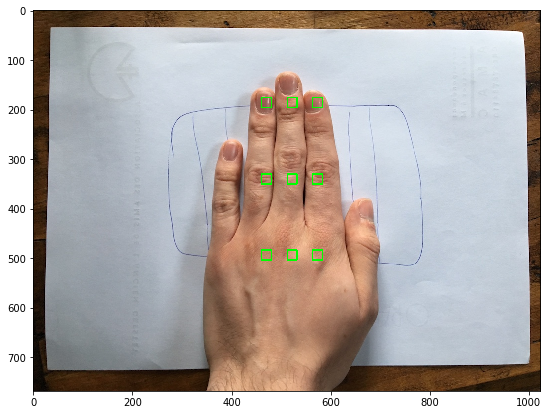

In [7]:
show(detector.hint(calib), gray=False)
plt.imsave("output/roi.png", detector.hint(calib));

On utilise ensuite l'image correspondante (appelée image de calibration) afin de construire un modèle de peau (voir la classe `SkinDetector` ci-dessus pour les détails d'implémentation).

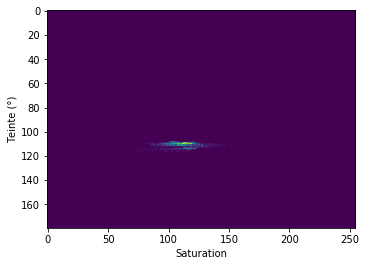

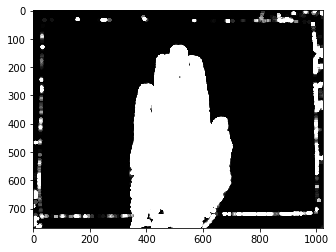

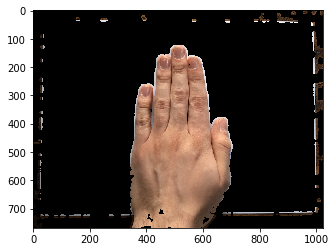

In [8]:
hist = detector.fit(calib)

# Affichage des résultats.

fig = plt.figure()
plt.imshow(hist, interpolation="nearest")
plt.xlabel("Saturation")
plt.ylabel("Teinte (°)");
plt.savefig("output/bp-hist.png");

fig = plt.figure()
plt.imshow(detector.project(calib), cmap="gray");
plt.savefig("output/bp-project.png");

fig = plt.figure()
plt.imshow(detector.transform(calib), cmap="gray");
plt.savefig("output/bp-transform.png");

On peut alors utiliser le détecteur pour extraire la peau d'images qui n'ont jamais été vues.

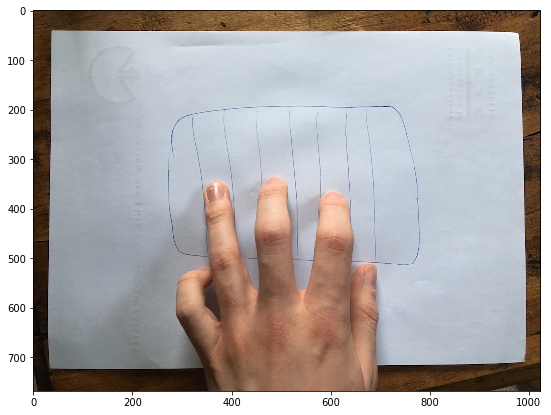

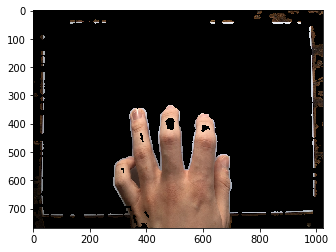

In [9]:
# Extraction de la main sur l'image "Scène avec doigts".
show(doigt, gray=False);

fig = plt.figure();
plt.imshow(detector.transform(doigt))
plt.savefig("output/bp-generalization.png");

Les résultants sont plutôt satisfaisants : la main est bien isolée du reste de l'image.

Les défauts tels que les faux négatifs au niveau de la main et les fauxpositifs au niveau du décor de la scène (provenant du fait que la table est d'une teinte plutôt similaire à celle de la main) ne sont *a priori* pas gênants. En effet, ils ne changeront pas le contour le plus long — qui est ici bien la main du pianiste.

## Localisation des doigts

Inspiré de [Fingertip detection on OpenCV](https://picoledelimao.github.io/blog/2015/11/15/fingertip-detection-on-opencv/).

In [10]:
from contextlib import contextmanager
from sklearn.cluster import KMeans


def farthest(n, defects, contour, centroid):
    s = defects[:, 0][:, 0]
    x = np.array(contour[s][:, 0][:, 0], dtype=np.float)
    y = np.array(contour[s][:, 0][:, 1], dtype=np.float)
    cx, cy = centroid

    # Les doigts du pianiste sont forcément dans la région supérieure de l'image.
    mask = (y < cy)
    x, y, s = x[mask], y[mask], s[mask]

    # Il peut y avoir plusieurs sommets par doigt (sommets redondants).
    # On applique un KMeans et on les remplace par le centroïde de leur cluster.
    points = np.vstack([x, y]).T
    kmeans = KMeans(n_clusters=n).fit(points)
    cluster_idx = np.unique(kmeans.predict(points))
    points = kmeans.cluster_centers_[cluster_idx].T
    assert points.shape[1] == n

    x, y = points

    # Calcul des distances (au carré) au centroïde.
    d2 = (x - cx) ** 2 + (y - cy) ** 2

    # Détermination des n points les plus lointains.
    indices = d2.argsort()[::-1][:n]
    return np.array([points[:, index] for index in indices])


# Mettre à True pour activer l'affichage des images de debug.
DEBUG = True

@contextmanager
def debug(img, **kwargs):
    img = img.copy()
    yield img
    if DEBUG:
        plt.figure(figsize=(10, 7))
        plt.imshow(img, **kwargs)


def detect_fingers(img, hand):
    """Détecte la position des doigts sur une image."""
    # Calcul des contours.
    gray = cv2.cvtColor(hand, cv2.COLOR_RGB2GRAY)
    # Mise à 255 de tous les pixels non-nuls.
    _, thresh = cv2.threshold(gray, 0, 255, 0)
    _, contours, _  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)	

    with debug(thresh, cmap="gray") as t:
        pass

    if not contours:
        return img

    # Obtention du contour d'aire maximale (= main).
    areas = [cv2.contourArea(cnt) for cnt in contours]
    contour, _ = max(zip(contours, areas), key=lambda t: t[1])

    with debug(img) as d:
        cv2.drawContours(d, [contour], 0, (0,255,0), 3)

    # Détermination du centroïde du contour (centre de la main).
    centroid = None
    moments = cv2.moments(contour)
    if moments['m00'] != 0:
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
        centroid = (cx, cy)

    # Calcul des défauts de convexité (~= sommets) de l'enveloppe convexe.
    hull_ = cv2.convexHull(contour, returnPoints=False)
    defects = None
    if hull_ is not None and len(hull_ > 3) and len(contour) > 3:
        defects = cv2.convexityDefects(contour, hull_)

    if centroid is None or not np.any(defects):
        return img

    with debug(img) as d:
        # Affichage de l'enveloppe convexe, du centroïde et des sommets.
        hull = cv2.convexHull(contour)
        cv2.drawContours(d, [hull], 0, (0, 255, 0), 3)
        cv2.circle(d, centroid, 10, [255, 0, 0], -1)
        s = defects[:, 0][:, 0]
        x = np.array(contour[s][:, 0][:, 0], dtype=np.float)
        y = np.array(contour[s][:, 0][:, 1], dtype=np.float)
        for xi, yi in zip(x, y):
            cv2.circle(d, (int(xi), int(yi)), 10, [0, 0, 255], -1)

    # Détermination des sommets 5 les plus éloignés du centroïde.
    farthest_points = farthest(5, defects, contour, centroid)

    # Construction de l'image finale.
    res = img.copy()
    for (x, y) in farthest_points:
        cv2.circle(res, (int(x), int(y)), 10, [255, 0, 0], -1)

    return res

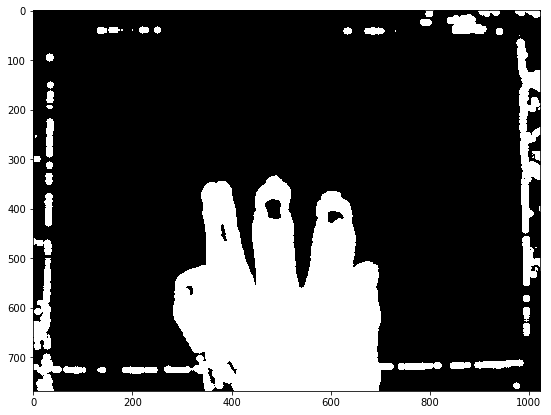

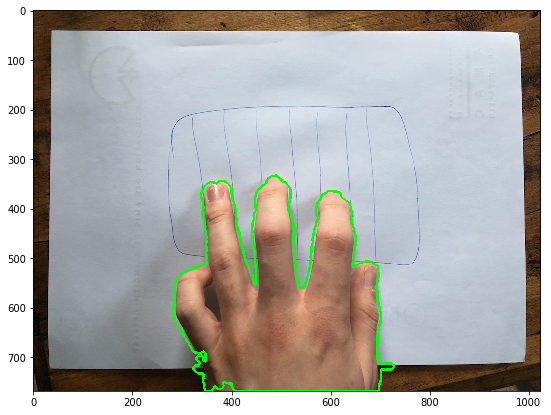

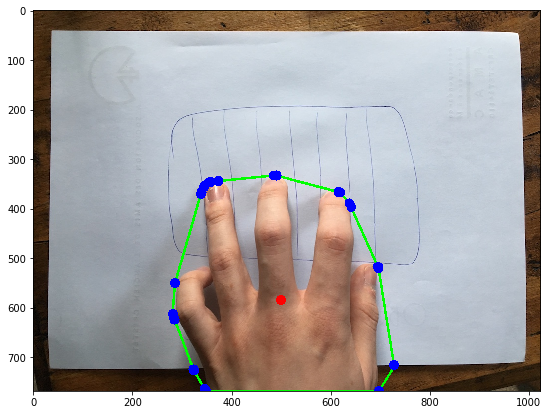

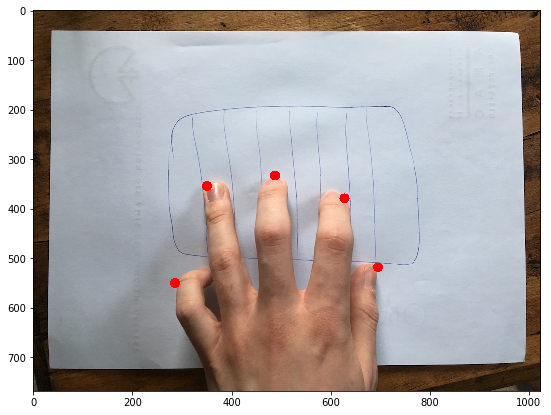

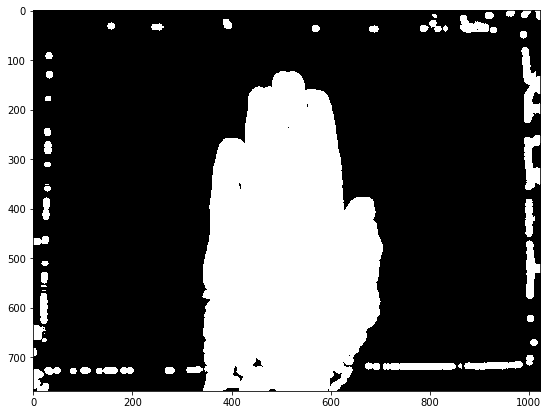

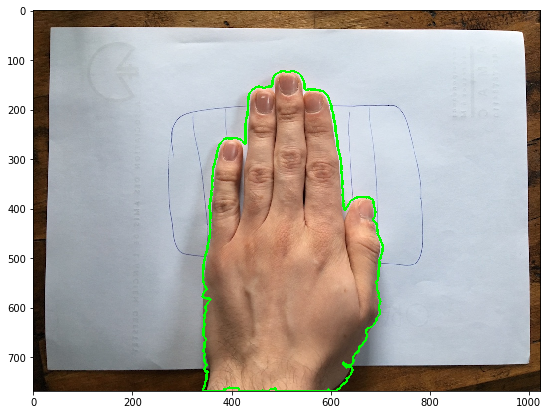

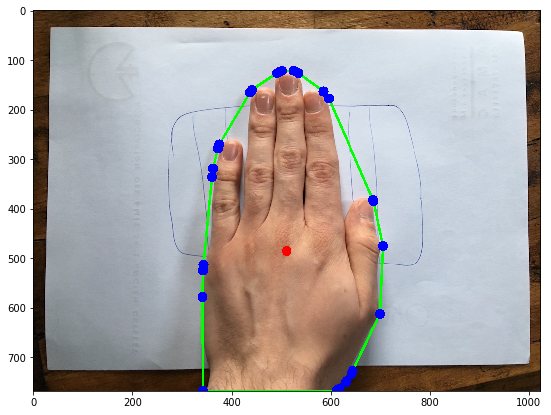

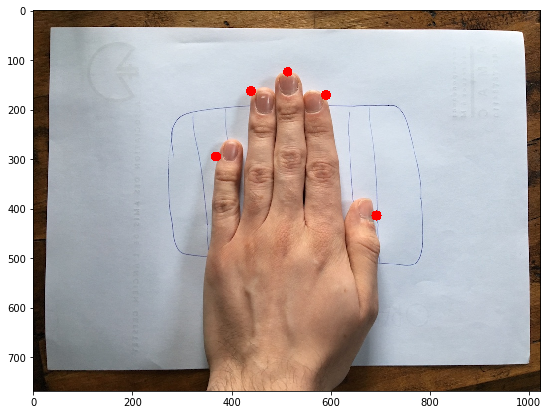

In [11]:
calib, _ = load("./data/images/piano-calib.jpg", gray=False)
skin_det = SkinDetector(calib.shape)
skin_det.fit(calib)

def _detect(img):
    res = detect_fingers(img, skin_det.transform(img))
    plt.figure(figsize=(10, 7))
    plt.imshow(res);
    
_detect(doigt)
_detect(calib)